In [2]:
!pip install -q kaggle nibabel

In [3]:
!ls /kaggle/input/brats20-dataset-training-validation

BraTS2020_TrainingData	BraTS2020_ValidationData


In [4]:
#Validate the data 
import os

# Path to MICCAI training data
training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# List first 5 patient folders
print("Patient folders:", os.listdir(training_path)[:5])


Patient folders: ['BraTS20_Training_083', 'BraTS20_Training_337', 'BraTS20_Training_161', 'BraTS20_Training_198', 'BraTS20_Training_284']


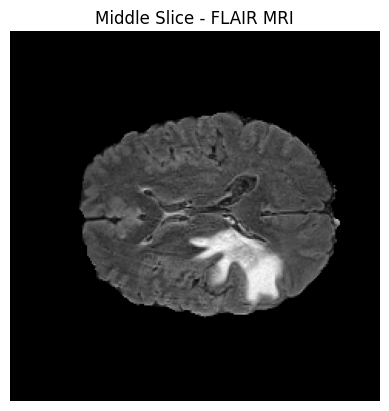

In [5]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

# Choose a patient folder
base_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
patient_id = "BraTS20_Training_083"
patient_path = os.path.join(base_path, patient_id)

# Load the FLAIR MRI scan
flair_path = os.path.join(patient_path, f"{patient_id}_flair.nii")
flair_img = nib.load(flair_path)
flair_data = flair_img.get_fdata()

# Show the middle slice
plt.imshow(flair_data[:, :, flair_data.shape[2] // 2], cmap="gray")
plt.title("Middle Slice - FLAIR MRI")
plt.axis("off")
plt.show()


1. Prepare the Dataset for Training
        * Resize images to a consistent shape (e.g., 256x256)
        * Normalize pixel intensities
        * Pair each MRI scan with its segmentation mask (_seg.nii files)
        * Create a PyTorch Dataset class

In [6]:
import numpy as np
zero_slices = [i for i in range(155) if np.sum(flair_data[:, :, i]) == 0]
print(zero_slices)

[141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]


In [2]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class BraTSDataset2D(Dataset):
    def __init__(self, root_dir, target_size=(240, 240)):
        self.root_dir = root_dir
        self.target_size = target_size
        self.slice_infos = []  # (flair_path, seg_path, slice_index)

        patients = [d for d in os.listdir(root_dir) if d.startswith("BraTS20")]
        for pid in patients:
            base = os.path.join(root_dir, pid)
            flair_path = os.path.join(base, f"{pid}_flair.nii")
            seg_path = os.path.join(base, f"{pid}_seg.nii")

            if os.path.exists(flair_path) and os.path.exists(seg_path):
                flair_vol = nib.load(flair_path).get_fdata()
                seg_vol = nib.load(seg_path).get_fdata()

                for i in range(seg_vol.shape[2]):  # 155 slices
                    if np.sum(seg_vol[:, :, i]) > 0:  # Only tumor slices
                        self.slice_infos.append((flair_path, seg_path, i))

    def __len__(self):
        return len(self.slice_infos)

    def __getitem__(self, idx):
        flair_path, seg_path, slice_idx = self.slice_infos[idx]

        flair_vol = nib.load(flair_path).get_fdata().astype(np.float32)
        seg_vol = nib.load(seg_path).get_fdata().astype(np.uint8)

        flair = flair_vol[:, :, slice_idx]
        seg = seg_vol[:, :, slice_idx]

        # Normalize FLAIR
        mn, mx = flair.min(), flair.max()
        if mx > mn:
            flair = (flair - mn) / (mx - mn)
        else:
            flair = np.zeros_like(flair)

        # Resize both flair and mask
        flair = F.interpolate(
            torch.from_numpy(flair).unsqueeze(0).unsqueeze(0),  # [1, 1, H, W]
            size=self.target_size,
            mode='bilinear',
            align_corners=False
        ).squeeze(0)  # [1, H, W] — channel retained

        seg = F.interpolate(
            torch.from_numpy(seg).unsqueeze(0).unsqueeze(0).float(),  # [1, 1, H, W]
            size=self.target_size,
            mode='nearest'
        ).squeeze(0).long()  # [1, H, W]

        return flair, seg

In [8]:
from torch.utils.data import DataLoader
import numpy as np
import torch

training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D(training_path)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Sanity check
for images, masks in dataloader:
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    break


Images shape: torch.Size([2, 1, 240, 240])
Masks shape: torch.Size([2, 1, 240, 240])


In [9]:
for flair, mask in dataloader:
    # Remove batch and channel dims
    mask_np = mask[0].squeeze().numpy()

    # Check the unique values in the mask
    print("Unique mask values:", np.unique(mask_np))

    # Check the total mask pixel values
    print("Sum of mask:", np.sum(mask_np))

    break

Unique mask values: [0 1 2]
Sum of mask: 4382


Unique mask values: [0 1 2 4]
Sum of mask: 4603


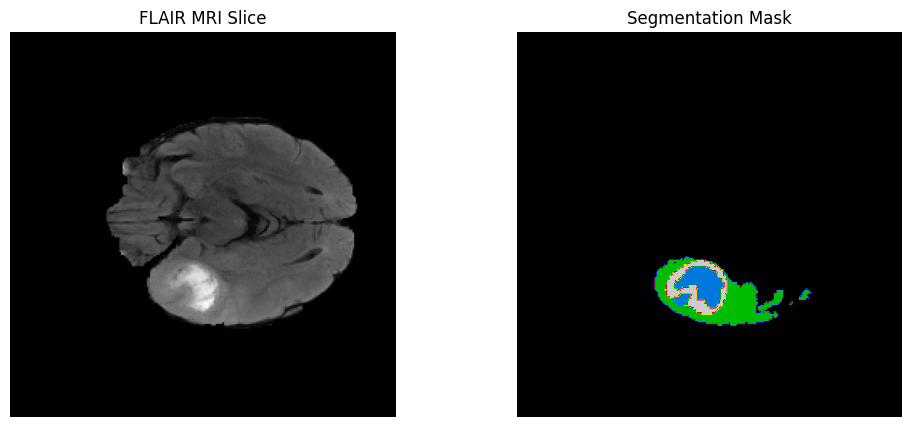

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load a single batch from the dataloader
for flair, mask in dataloader:
    # Get first item from batch
    flair_img = flair[0].squeeze().numpy()  # shape: (240, 240)
    mask_img = mask[0].squeeze().numpy()    # shape: (240, 240)

    print("Unique mask values:", np.unique(mask_img))  # Should include 1, 2, or 4
    print("Sum of mask:", np.sum(mask_img))            # Should be > 0

    # Plot
    plt.figure(figsize=(12, 5))

    # FLAIR image
    plt.subplot(1, 2, 1)
    plt.imshow(flair_img, cmap='gray')
    plt.title("FLAIR MRI Slice")
    plt.axis('off')

    # Segmentation mask (color-coded)
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img, cmap='nipy_spectral', vmin=0, vmax=4)
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.show()
    break

Split the data into training and testing

In [11]:
from torch.utils.data import random_split

# Total number of patients
total_patients = len([d for d in os.listdir(training_path) if d.startswith("BraTS20")])

# Define ratios
train_ratio = 0.8
val_ratio = 0.2

# Number of patients for each split
train_size = int(train_ratio * total_patients)
val_size = total_patients - train_size

# List of patients
all_patients = [d for d in os.listdir(training_path) if d.startswith("BraTS20")]
all_patients.sort()  # Optional: make split reproducible

# Actual patient folder paths
train_patients = all_patients[:train_size]
val_patients = all_patients[train_size:]


3. Building the U-Net Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


In [13]:
from torch.utils.data import DataLoader, random_split

# 1. Load your dataset
training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D(training_path)

# 2. Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 3. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

# 4. Set up model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [14]:
print(type(train_dataset))
print(type(val_dataset))


<class 'torch.utils.data.dataset.Subset'>
<class 'torch.utils.data.dataset.Subset'>


In [15]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [16]:
print("Image shape:", images.shape)  # Should be [B, 1, 240, 240]

Image shape: torch.Size([2, 1, 240, 240])


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time

# Dataset
training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D(training_path)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,
                          pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,
                        pin_memory=True, persistent_workers=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=1, out_channels=5).to(device)  # 5 output classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
torch.backends.cudnn.benchmark = True

# Training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}", unit="batch")

    for i, (images, masks) in enumerate(loop):
        start_time = time.time()

        try:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).squeeze(1).long()

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            if torch.isnan(loss):
                loop.write(f"[ NaN] Skipping batch {i}")
                continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            avg_loss = epoch_loss / (i + 1)
            loop.set_postfix(loss=avg_loss)

        except Exception as e:
            loop.write(f"[ Skipping batch {i}] Error: {e}")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[ERROR] Epoch {epoch}, Batch {i}, Error: {str(e)}\n")
            continue

        #  Log long batch duration
        duration = time.time() - start_time
        if duration > 15:  # Adjust this threshold based on what "slow" means for you
            loop.write(f"[ Warning] Batch {i} took {duration:.2f}s.")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[SLOW] Epoch {epoch}, Batch {i}, Time: {duration:.2f}s\n")

    print(f" Epoch {epoch} — Avg Loss: {epoch_loss / len(train_loader):.4f}")

Using device: cuda


/tmp/ipykernel_31/2802123598.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
[Train] Epoch 1/5:   0%|          | 0/2435 [00:00<?, ?batch/s]/tmp/ipykernel_31/2802123598.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[Train] Epoch 1/5: 100%|██████████| 2435/2435 [10:27<00:00,  3.88batch/s, loss=0.0758]


 Epoch 1 — Avg Loss: 0.0758


[Train] Epoch 2/5: 100%|██████████| 2435/2435 [10:26<00:00,  3.88batch/s, loss=0.0388]


 Epoch 2 — Avg Loss: 0.0388


[Train] Epoch 3/5: 100%|██████████| 2435/2435 [10:22<00:00,  3.91batch/s, loss=0.0318]


 Epoch 3 — Avg Loss: 0.0318


[Train] Epoch 4/5: 100%|██████████| 2435/2435 [10:22<00:00,  3.91batch/s, loss=0.0252]


 Epoch 4 — Avg Loss: 0.0252


[Train] Epoch 5/5: 100%|██████████| 2435/2435 [10:25<00:00,  3.90batch/s, loss=0.0206]

 Epoch 5 — Avg Loss: 0.0206


In [19]:
# Save the trained model weights
torch.save(model.state_dict(), "unet_final.pt")
print("Model saved as unet_final.pt")

Model saved as unet_final.pt


In [20]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
model.eval()
# Load trained model
model = UNet(in_channels=1, out_channels=5).to(device)
model.load_state_dict(torch.load("unet_final.pt", map_location=device))

/tmp/ipykernel_31/1966908193.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_final.pt", map_location=device))


<All keys matched successfully>

In [22]:
model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)  # [B, 5, H, W]
    preds = torch.argmax(outputs, dim=1)  # [B, H, W]

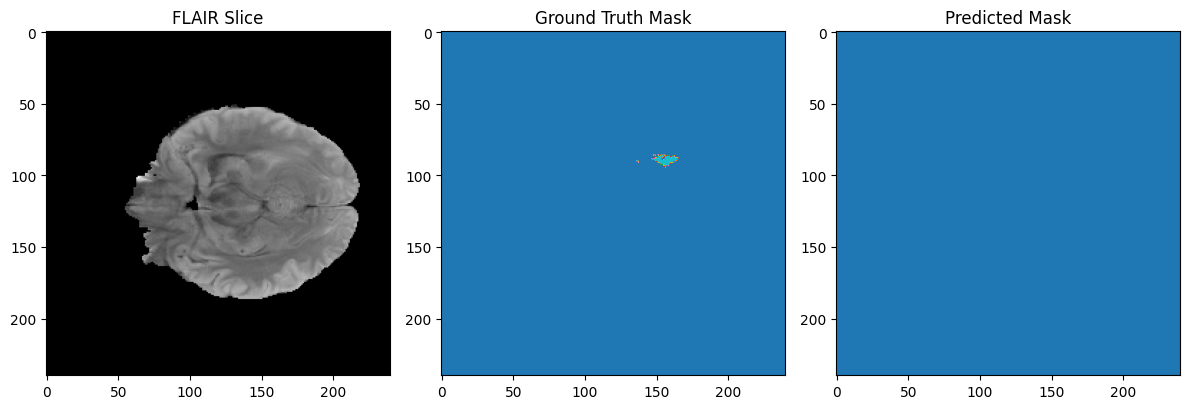

In [25]:
import matplotlib.pyplot as plt

idx = 0  # index of image in the batch

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(images[idx].cpu().squeeze(), cmap="gray")
plt.title("FLAIR Slice")

plt.subplot(1, 3, 2)
plt.imshow(masks[idx].cpu().squeeze(), cmap="tab10")
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(preds[idx].cpu(), cmap="tab10")
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [26]:
import torch

def dice_score(preds, targets, num_classes=5, ignore_index=0, eps=1e-6):
    preds = torch.argmax(preds, dim=1)  # [B, H, W]
    dice_per_class = []

    for cls in range(num_classes):
        if cls == ignore_index:
            continue  # skip background

        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2 * intersection + eps) / (union + eps)
        dice_per_class.append(dice.item())

    mean_dice = sum(dice_per_class) / len(dice_per_class)
    return dice_per_class, mean_dice

In [ ]:
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device).squeeze(1).long()

with torch.no_grad():
    outputs = model(images)  # [B, 5, H, W]

In [29]:
device = outputs.device  # assumes outputs is already on the right device
masks = masks.to(device)  # move masks to same device as outputs

dice_per_class, mean_dice = dice_score(outputs, masks)

for i, score in enumerate(dice_per_class, 1):
    print(f"Dice Score for Class {i}: {score:.4f}")

print(f"\ Mean Dice Score (no background): {mean_dice:.4f}")

Dice Score for Class 1: 1.2410
Dice Score for Class 2: 1.4545
Dice Score for Class 3: 1.0000
Dice Score for Class 4: 0.6943
\ Mean Dice Score (no background): 1.0975


NEW

NEW

In [5]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class BraTSDataset2D_WithHealthy(Dataset):
    def __init__(self, root_dir, target_size=(240, 240), include_healthy=True, healthy_ratio=0.5):
        self.root_dir = root_dir
        self.target_size = target_size
        self.slice_infos = []
        
        tumor_slices = []
        healthy_slices = []

        patients = [d for d in os.listdir(root_dir) if d.startswith("BraTS20")]
        for pid in patients:
            base = os.path.join(root_dir, pid)
            flair_path = os.path.join(base, f"{pid}_flair.nii")
            seg_path = os.path.join(base, f"{pid}_seg.nii")

            if os.path.exists(flair_path) and os.path.exists(seg_path):
                seg_vol = nib.load(seg_path).get_fdata()
                for i in range(seg_vol.shape[2]):
                    if np.sum(seg_vol[:, :, i]) > 0:
                        tumor_slices.append((flair_path, seg_path, i))
                    elif include_healthy:
                        healthy_slices.append((flair_path, seg_path, i))

        self.slice_infos.extend(tumor_slices)

        if include_healthy:
            np.random.shuffle(healthy_slices)
            healthy_limit = int(len(tumor_slices) * healthy_ratio)
            self.slice_infos.extend(healthy_slices[:healthy_limit])

        np.random.shuffle(self.slice_infos)

    def __len__(self):
        return len(self.slice_infos)

    def __getitem__(self, idx):
        flair_path, seg_path, slice_idx = self.slice_infos[idx]

        flair_vol = nib.load(flair_path).get_fdata().astype(np.float32)
        seg_vol = nib.load(seg_path).get_fdata().astype(np.uint8)

        flair = flair_vol[:, :, slice_idx]
        seg = seg_vol[:, :, slice_idx]

        mn, mx = flair.min(), flair.max()
        flair = (flair - mn) / (mx - mn) if mx > mn else np.zeros_like(flair)

        flair_tensor = F.interpolate(torch.from_numpy(flair).unsqueeze(0).unsqueeze(0), size=self.target_size, mode='bilinear', align_corners=False).squeeze()
        seg_tensor = F.interpolate(torch.from_numpy(seg).unsqueeze(0).unsqueeze(0).float(), size=self.target_size, mode='nearest').squeeze().long()

        return flair_tensor.unsqueeze(0), seg_tensor


In [6]:
from torch.utils.data import DataLoader
import numpy as np
import torch

training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D_WithHealthy(training_path)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# Sanity check
for images, masks in dataloader:
    print(" Images shape:", images.shape)
    print(" Masks shape:", masks.shape)
    break


 Images shape: torch.Size([2, 1, 240, 240])
 Masks shape: torch.Size([2, 240, 240])


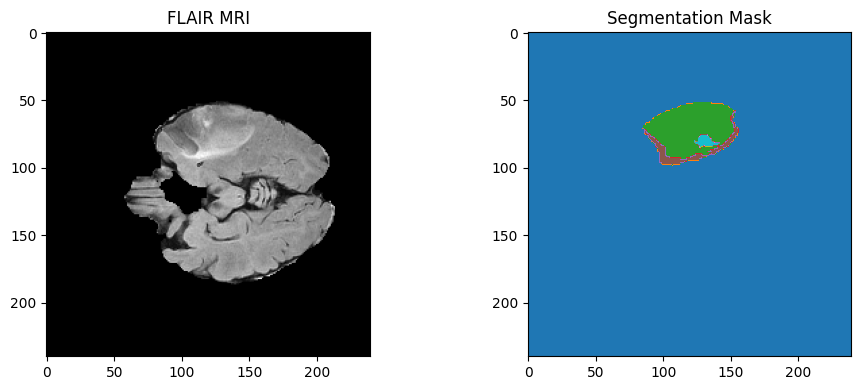

In [9]:
import matplotlib.pyplot as plt

images, masks = next(iter(dataloader))
i = 0  # change this to view different samples

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[i][0].numpy(), cmap="gray")
plt.title("FLAIR MRI")

plt.subplot(1, 2, 2)
plt.imshow(masks[i].numpy(), cmap="tab10")
plt.title("Segmentation Mask")

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time

# Dataset
training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D_WithHealthy(training_path)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,
                          pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,
                        pin_memory=True, persistent_workers=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNet(in_channels=1, out_channels=5).to(device)  # 5 output classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
torch.backends.cudnn.benchmark = True

# Training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}", unit="batch")

    for i, (images, masks) in enumerate(loop):
        start_time = time.time()

        try:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).squeeze(1).long()

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            if torch.isnan(loss):
                loop.write(f"[ NaN] Skipping batch {i}")
                continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            avg_loss = epoch_loss / (i + 1)
            loop.set_postfix(loss=avg_loss)

        except Exception as e:
            loop.write(f"[ Skipping batch {i}] Error: {e}")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[ERROR] Epoch {epoch}, Batch {i}, Error: {str(e)}\n")
            continue

        #  Log long batch duration
        duration = time.time() - start_time
        if duration > 15:  # Adjust this threshold based on what "slow" means for you
            loop.write(f"[ Warning] Batch {i} took {duration:.2f}s.")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[SLOW] Epoch {epoch}, Batch {i}, Time: {duration:.2f}s\n")

    print(f"Epoch {epoch} — Avg Loss: {epoch_loss / len(train_loader):.4f}")

Using device: cuda


/tmp/ipykernel_31/1839269770.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
[Train] Epoch 1/5:   0%|          | 0/3653 [00:00<?, ?batch/s]/tmp/ipykernel_31/1839269770.py:50: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
[Train] Epoch 1/5:  68%|██████▊   | 2472/3653 [11:00<05:03,  3.89batch/s, loss=0.0651]

In [ ]:
# Save the trained model weights
torch.save(model.state_dict(), "unet_with_healthy.pt")
print("Model saved as unet_with_healthy.pt")

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load trained model
model = UNet(in_channels=1, out_channels=5).to(device)
model.load_state_dict(torch.load("unet_with_healthy.pt", map_location=device))
model.eval()

In [ ]:
model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)  # [B, 5, H, W]
    preds = torch.argmax(outputs, dim=1)  # [B, H, W]

In [ ]:
import matplotlib.pyplot as plt

idx = 3  # index of image in the batch

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(images[idx].cpu().squeeze(), cmap="gray")
plt.title("FLAIR Slice")

plt.subplot(1, 3, 2)
plt.imshow(masks[idx].cpu().squeeze(), cmap="tab10")
plt.title("Ground Truth Mask")

plt.subplot(1, 3, 3)
plt.imshow(preds[idx].cpu(), cmap="tab10")
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

In [ ]:
import torch

def dice_score(preds, targets, num_classes=5, ignore_index=0, eps=1e-6):
    preds = torch.argmax(preds, dim=1)  # [B, H, W]
    dice_per_class = []

    for cls in range(num_classes):
        if cls == ignore_index:
            continue  # skip background

        pred_cls = (preds == cls).float()
        target_cls = (targets == cls).float()

        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()

        dice = (2 * intersection + eps) / (union + eps)
        dice_per_class.append(dice.item())

    mean_dice = sum(dice_per_class) / len(dice_per_class)
    return dice_per_class, mean_dice

In [ ]:
images, masks = next(iter(val_loader))
images = images.to(device)
masks = masks.to(device).squeeze(1).long()

with torch.no_grad():
    outputs = model(images)  # [B, 5, H, W]

In [ ]:
dice_per_class, mean_dice = dice_score(outputs, masks)

for i, score in enumerate(dice_per_class, 1):
    print(f"" Dice Score for Class {i}: {score:.4f}")

print(f"\n Mean Dice Score (no background): {mean_dice:.4f}")

In [ ]:
# Grab a batch from your validation set
for images, masks in val_loader:
    for i in range(images.shape[0]):
        mask = masks[i].squeeze().cpu().numpy()

        if np.max(mask) == 0:  # All pixels are background (healthy slice)
            image = images[i].squeeze().cpu().numpy()

            # Plot the FLAIR and empty mask
            import matplotlib.pyplot as plt

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(image, cmap='gray')
            plt.title("Healthy FLAIR MRI")

            plt.subplot(1, 2, 2)
            plt.imshow(mask, cmap='gray')
            plt.title("Healthy Mask (All 0s)")

            plt.tight_layout()
            plt.show()
            break  # Stop after first healthy sample
    break

In [ ]:
with torch.no_grad():
    pred = model(images.to(device))[i].unsqueeze(0)  # Single slice
    pred_label = torch.argmax(pred, dim=1).squeeze().cpu().numpy()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Healthy FLAIR")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth (All 0s)")

plt.subplot(1, 3, 3)
plt.imshow(pred_label, cmap='tab10')
plt.title("Predicted Mask")

plt.tight_layout()
plt.show()

CBAM model

In [ ]:
# cbam.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(concat))

class CBAM(nn.Module):
    def __init__(self, in_planes):
        super(CBAM, self).__init__()
        self.channel = ChannelAttention(in_planes)
        self.spatial = SpatialAttention()

    def forward(self, x):
        x = x * self.channel(x)
        x = x * self.spatial(x)
        return x

In [ ]:


class UNetCBAM(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNetCBAM, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                CBAM(out_c)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))

        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time

# Dataset
training_path = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
dataset = BraTSDataset2D_WithHealthy(training_path)

# Train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4,
                          pin_memory=True, persistent_workers=True, prefetch_factor=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4,
                        pin_memory=True, persistent_workers=True)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = UNetCBAM(in_channels=1, out_channels=5).to(device)  # 5 output classes
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler()
torch.backends.cudnn.benchmark = True

# Training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0
    loop = tqdm(train_loader, desc=f"[Train] Epoch {epoch}/{num_epochs}", unit="batch")

    for i, (images, masks) in enumerate(loop):
        start_time = time.time()

        try:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True).squeeze(1).long()

            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)

            if torch.isnan(loss):
                loop.write(f"[NaN] Skipping batch {i}")
                continue

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
            avg_loss = epoch_loss / (i + 1)
            loop.set_postfix(loss=avg_loss)

        except Exception as e:
            loop.write(f"[ Skipping batch {i}] Error: {e}")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[ERROR] Epoch {epoch}, Batch {i}, Error: {str(e)}\n")
            continue

        # Log long batch duration
        duration = time.time() - start_time
        if duration > 15:  # Adjust this threshold based on what "slow" means for you
            loop.write(f"[ Warning] Batch {i} took {duration:.2f}s.")
            with open("slow_batches.txt", "a") as f:
                f.write(f"[SLOW] Epoch {epoch}, Batch {i}, Time: {duration:.2f}s\n")

    print(f" Epoch {epoch} — Avg Loss: {epoch_loss / len(train_loader):.4f}")

In [ ]:
# Save the trained model weights
torch.save(model.state_dict(), "unetCBAM_with_healthy.pt")
print(" Model saved as unetCBAM_with_healthy.pt")

In [ ]:
model = UNetCBAM(in_channels=1, out_channels=5).to(device)
model.load_state_dict(torch.load("unetCBAM_with_healthy.pt"))  # or your saved checkpoint
model.eval()

In [ ]:
model.eval()
images, masks = next(iter(val_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)  # [B, 5, H, W]
    preds = torch.argmax(outputs, dim=1)  # [B, H, W]

In [ ]:
dice_per_class, mean_dice = dice_score(outputs, masks)

for i, score in enumerate(dice_per_class, 1):
    print(f"🎯 Dice Score for Class {i}: {score:.4f}")

print(f"\n🔥 Mean Dice Score (no background): {mean_dice:.4f}")